In [1]:
import os
from google.colab import drive, auth
import pandas as pd
import math
import seaborn as sns
# Mount Google Drive - This will prompt you to click a link to authorize
drive.mount('/content/drive')

# Navigate to directory and list files
os.chdir('drive/My Drive/Year 2 NEU/Spring 2021/Machine Learning 1/Final Project')
os.listdir('.')

Mounted at /content/drive


['images_filtered.zip',
 'FP.ipynb',
 'cleaned_filtered.csv',
 'checkpoints',
 'Image_Labels_Subset_Train_GCC-Labels-training (1).tsv',
 'images_filtered',
 'senticap_dataset.json',
 'senticap.json',
 'senti_cap_sent.csv',
 'FP_1.ipynb',
 'feature_set',
 'feature_set_VGG',
 'sent_added',
 'sent_added_30k',
 'Copy of 30k_sample.zip',
 '30k_sample',
 'feature_set_VGG_30k',
 'FP_2.ipynb',
 'val2014',
 'FP_3.ipynb']

In [2]:
import tensorflow as tf

# You'll generate plots of attention in order to see which parts of an image
# our model focuses on during captioning
import matplotlib.pyplot as plt

# Scikit-learn includes many helpful utilities
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import collections
import random
import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle
from tqdm import tqdm

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
feature_set = pd.read_csv('feature_set_VGG_30k', index_col=0)

In [5]:
feature_set

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,4057,4058,4059,4060,4061,4062,4063,4064,4065,4066,4067,4068,4069,4070,4071,4072,4073,4074,4075,4076,4077,4078,4079,4080,4081,4082,4083,4084,4085,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095,sentiment
552309,0.000000,0.358158,1.393375,0.000000,1.070133,0.000000,0.0,0.0,0.348106,0.0,0.0,1.647137,1.195355,0.000000,0.915612,0.000000,0.199841,1.146108,0.043671,0.079740,1.321823,0.000000,0.000000,1.841485,0.118143,1.727436,0.0,1.333253,0.000000,0.365567,1.002836,1.129437,0.0,0.0,1.181362,0.414671,0.000000,1.804530,0.517370,2.319058,...,0.506205,0.812473,0.0,0.0,1.483065,0.811348,0.078459,0.302602,0.0,1.007142,0.343417,0.0,1.272803,1.379171,0.00000,0.632071,0.0,0.591897,0.0,0.0,0.870573,0.310886,0.000000,1.153894,0.000000,0.000000,0.456920,0.268792,0.000000,0.000000,0.597368,0.562119,0.046995,0.588401,0.211185,0.361641,0.0,0.0,1.002938,NEGATIVE
225955,0.000000,0.000000,1.115743,0.000000,1.200688,0.000000,0.0,0.0,0.201822,0.0,0.0,1.831420,1.214641,0.000000,1.088806,0.000000,0.000000,0.234902,0.276907,0.000000,1.290513,0.000000,0.380937,1.617023,0.568451,2.087044,0.0,0.746646,0.029916,0.000000,1.009066,1.409693,0.0,0.0,0.500073,0.711918,0.088380,1.296978,0.045482,2.505255,...,0.569608,0.888691,0.0,0.0,1.500837,0.261320,0.907124,0.364622,0.0,1.200511,0.829808,0.0,1.530730,1.107422,0.00000,1.273498,0.0,0.533062,0.0,0.0,0.551523,0.000000,0.000000,1.032367,0.000000,0.000000,0.000000,0.940149,0.000000,0.183738,0.927505,1.231018,0.451520,0.859181,0.000000,0.179940,0.0,0.0,0.615112,POSITIVE
1415488,0.000000,0.028129,0.829865,0.159302,1.206197,0.001449,0.0,0.0,0.556073,0.0,0.0,1.583965,1.151859,0.359410,1.429509,0.076319,0.610382,0.606019,0.677147,0.019762,1.128937,0.000000,0.192496,1.603688,0.441526,1.957681,0.0,1.034948,0.000000,0.198288,1.149151,1.186697,0.0,0.0,0.794035,0.084121,0.244170,1.825590,0.000000,2.172408,...,0.670792,0.891697,0.0,0.0,1.775978,0.414991,0.407884,0.598824,0.0,1.143500,0.423352,0.0,1.509410,0.945316,0.00000,0.692542,0.0,1.237016,0.0,0.0,0.972290,0.116769,0.000000,1.149972,0.300431,0.627788,0.079388,0.434190,0.206834,0.000000,0.608359,0.550911,0.082753,0.658275,0.383880,0.000000,0.0,0.0,0.611961,POSITIVE
1158867,0.000000,0.026218,1.449509,0.044714,0.898397,0.125851,0.0,0.0,0.443495,0.0,0.0,1.519036,1.055241,0.184231,1.312127,0.137027,0.000000,0.296208,0.578755,0.130167,1.193491,0.000000,1.033107,1.698923,0.472265,1.733366,0.0,1.084371,0.000000,0.047994,1.203933,1.213649,0.0,0.0,0.443960,0.362823,0.284882,1.674579,0.201328,2.504062,...,0.470771,1.240609,0.0,0.0,1.850930,0.850375,1.072851,0.293941,0.0,1.087222,1.028412,0.0,1.784051,0.999501,0.00000,0.992328,0.0,0.905943,0.0,0.0,0.756100,0.351715,0.195506,1.198341,0.000000,0.000000,0.065406,0.834483,0.000000,0.021464,1.021127,1.357046,0.567825,1.097753,0.000000,0.262271,0.0,0.0,0.818601,NEGATIVE
218113,0.000000,0.045783,1.419600,0.000000,1.080155,0.004058,0.0,0.0,0.575584,0.0,0.0,1.435195,0.377093,0.000000,1.318668,0.000000,0.000000,0.111402,0.439438,0.000000,1.842853,0.000000,0.847778,1.792945,0.000000,1.589232,0.0,1.124045,0.064144,0.000000,0.777684,1.350623,0.0,0.0,0.416492,0.000000,0.096921,1.375911,0.000000,2.394983,...,0.314514,1.014695,0.0,0.0,2.060770,0.297445,1.187685,0.212327,0.0,0.922818,0.725754,0.0,1.683646,0.693827,0.00000,0.634510,0.0,0.846848,0.0,0.0,0.873359,0.111643,0.000000,1.005215,0.095233,0.226850,0.206556,1.000117,0.000000,0.239947,0.964624,1.094558,0.168111,0.661828,0.490530,0.748734,0.0,0.0,0.197746,POSITIVE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
471205,0.000000,0.000000,1.508535,0.065465,0.772293,0.318940,0.0,0.0,0.481302,0.0,0.0,1.574216,1.296

In [6]:
import sklearn

# DATASET


In [7]:
from sklearn.linear_model import LogisticRegression as LR
from sklearn.preprocessing import OneHotEncoder
import random

In [8]:
# feature_set['sentiment'] = feature_set['sentiment'].apply(lambda x: 1 if x == 'POSITIVE' else 0)

In [9]:
feature_set

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,4057,4058,4059,4060,4061,4062,4063,4064,4065,4066,4067,4068,4069,4070,4071,4072,4073,4074,4075,4076,4077,4078,4079,4080,4081,4082,4083,4084,4085,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095,sentiment
552309,0.000000,0.358158,1.393375,0.000000,1.070133,0.000000,0.0,0.0,0.348106,0.0,0.0,1.647137,1.195355,0.000000,0.915612,0.000000,0.199841,1.146108,0.043671,0.079740,1.321823,0.000000,0.000000,1.841485,0.118143,1.727436,0.0,1.333253,0.000000,0.365567,1.002836,1.129437,0.0,0.0,1.181362,0.414671,0.000000,1.804530,0.517370,2.319058,...,0.506205,0.812473,0.0,0.0,1.483065,0.811348,0.078459,0.302602,0.0,1.007142,0.343417,0.0,1.272803,1.379171,0.00000,0.632071,0.0,0.591897,0.0,0.0,0.870573,0.310886,0.000000,1.153894,0.000000,0.000000,0.456920,0.268792,0.000000,0.000000,0.597368,0.562119,0.046995,0.588401,0.211185,0.361641,0.0,0.0,1.002938,NEGATIVE
225955,0.000000,0.000000,1.115743,0.000000,1.200688,0.000000,0.0,0.0,0.201822,0.0,0.0,1.831420,1.214641,0.000000,1.088806,0.000000,0.000000,0.234902,0.276907,0.000000,1.290513,0.000000,0.380937,1.617023,0.568451,2.087044,0.0,0.746646,0.029916,0.000000,1.009066,1.409693,0.0,0.0,0.500073,0.711918,0.088380,1.296978,0.045482,2.505255,...,0.569608,0.888691,0.0,0.0,1.500837,0.261320,0.907124,0.364622,0.0,1.200511,0.829808,0.0,1.530730,1.107422,0.00000,1.273498,0.0,0.533062,0.0,0.0,0.551523,0.000000,0.000000,1.032367,0.000000,0.000000,0.000000,0.940149,0.000000,0.183738,0.927505,1.231018,0.451520,0.859181,0.000000,0.179940,0.0,0.0,0.615112,POSITIVE
1415488,0.000000,0.028129,0.829865,0.159302,1.206197,0.001449,0.0,0.0,0.556073,0.0,0.0,1.583965,1.151859,0.359410,1.429509,0.076319,0.610382,0.606019,0.677147,0.019762,1.128937,0.000000,0.192496,1.603688,0.441526,1.957681,0.0,1.034948,0.000000,0.198288,1.149151,1.186697,0.0,0.0,0.794035,0.084121,0.244170,1.825590,0.000000,2.172408,...,0.670792,0.891697,0.0,0.0,1.775978,0.414991,0.407884,0.598824,0.0,1.143500,0.423352,0.0,1.509410,0.945316,0.00000,0.692542,0.0,1.237016,0.0,0.0,0.972290,0.116769,0.000000,1.149972,0.300431,0.627788,0.079388,0.434190,0.206834,0.000000,0.608359,0.550911,0.082753,0.658275,0.383880,0.000000,0.0,0.0,0.611961,POSITIVE
1158867,0.000000,0.026218,1.449509,0.044714,0.898397,0.125851,0.0,0.0,0.443495,0.0,0.0,1.519036,1.055241,0.184231,1.312127,0.137027,0.000000,0.296208,0.578755,0.130167,1.193491,0.000000,1.033107,1.698923,0.472265,1.733366,0.0,1.084371,0.000000,0.047994,1.203933,1.213649,0.0,0.0,0.443960,0.362823,0.284882,1.674579,0.201328,2.504062,...,0.470771,1.240609,0.0,0.0,1.850930,0.850375,1.072851,0.293941,0.0,1.087222,1.028412,0.0,1.784051,0.999501,0.00000,0.992328,0.0,0.905943,0.0,0.0,0.756100,0.351715,0.195506,1.198341,0.000000,0.000000,0.065406,0.834483,0.000000,0.021464,1.021127,1.357046,0.567825,1.097753,0.000000,0.262271,0.0,0.0,0.818601,NEGATIVE
218113,0.000000,0.045783,1.419600,0.000000,1.080155,0.004058,0.0,0.0,0.575584,0.0,0.0,1.435195,0.377093,0.000000,1.318668,0.000000,0.000000,0.111402,0.439438,0.000000,1.842853,0.000000,0.847778,1.792945,0.000000,1.589232,0.0,1.124045,0.064144,0.000000,0.777684,1.350623,0.0,0.0,0.416492,0.000000,0.096921,1.375911,0.000000,2.394983,...,0.314514,1.014695,0.0,0.0,2.060770,0.297445,1.187685,0.212327,0.0,0.922818,0.725754,0.0,1.683646,0.693827,0.00000,0.634510,0.0,0.846848,0.0,0.0,0.873359,0.111643,0.000000,1.005215,0.095233,0.226850,0.206556,1.000117,0.000000,0.239947,0.964624,1.094558,0.168111,0.661828,0.490530,0.748734,0.0,0.0,0.197746,POSITIVE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
471205,0.000000,0.000000,1.508535,0.065465,0.772293,0.318940,0.0,0.0,0.481302,0.0,0.0,1.574216,1.296

In [10]:
feature_set['sentiment'].unique()

array(['NEGATIVE', 'POSITIVE'], dtype=object)

In [11]:
feature_set[feature_set['sentiment'] == 'NEGATIVE'].shape

(8912, 4097)

In [12]:
feature_set[feature_set['sentiment'] == 'POSITIVE'].shape

(21016, 4097)

In [13]:
feature_set[feature_set['sentiment'] =='POSITIVE'].shape[0]/feature_set.shape[0]

0.702218658112804

# Initialization and Scaling

In [14]:
target_col = 'sentiment'
X = feature_set.drop([target_col], axis=1)
y = feature_set[target_col]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2)

In [15]:
X_train

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,4056,4057,4058,4059,4060,4061,4062,4063,4064,4065,4066,4067,4068,4069,4070,4071,4072,4073,4074,4075,4076,4077,4078,4079,4080,4081,4082,4083,4084,4085,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
1251507,0.000000,0.000000,1.146352,0.000000,0.605698,0.080887,0.0,0.0,0.269569,0.0,0.0,1.815622,0.985777,0.000000,1.450913,0.000000,0.103134,0.000000,0.224441,0.000000,0.899944,0.000000,0.406045,1.469077,0.491366,1.817915,0.0,1.108762,0.000000,0.129921,1.037481,1.255133,0.0,0.0,0.360174,0.000000,0.235558,0.880280,0.000000,2.591792,...,0.000000,0.156192,1.437217,0.0,0.0,2.086835,0.437809,1.206263,0.113513,0.0,1.256983,0.985401,0.0,1.790240,0.804019,0.0,1.239182,0.0,0.707073,0.0,0.0,0.857459,0.000000,0.000000,1.200528,0.000000,0.187290,0.000000,0.497568,0.000000,0.000000,1.446613,0.985289,0.246334,0.588113,0.000000,0.490438,0.0,0.000000,0.656321
453846,0.000000,0.000000,0.974264,0.071783,1.200562,0.192189,0.0,0.0,0.923014,0.0,0.0,1.303174,0.923901,0.382083,1.473276,0.000000,0.242691,0.634268,0.878317,0.000000,1.284621,0.000000,0.472555,1.333169,0.000000,1.988926,0.0,1.322547,0.250076,0.710926,0.873101,0.960367,0.0,0.0,0.436496,0.000000,0.076660,1.687958,0.000000,2.389989,...,0.127219,0.562037,1.200190,0.0,0.0,1.850593,0.507084,0.453337,0.284011,0.0,0.825698,0.691231,0.0,1.678073,0.982560,0.0,0.667297,0.0,0.857320,0.0,0.0,0.707193,0.128963,0.000000,1.115211,0.188486,0.089714,0.000000,0.319671,0.027553,0.000000,0.929814,1.144503,0.153645,0.862887,0.000000,0.543100,0.0,0.016363,0.809095
1466486,0.000000,0.056272,1.479042,0.084603,0.625582,0.082335,0.0,0.0,0.738354,0.0,0.0,1.894018,0.622064,0.282784,1.195053,0.000000,0.000000,0.244706,0.438918,0.033536,1.757245,0.244598,0.852062,1.986234,0.061292,1.488665,0.0,1.256500,0.168723,0.000000,0.735851,1.422932,0.0,0.0,0.473971,0.000000,0.266711,1.564959,0.000000,2.457802,...,0.000000,0.125395,1.354595,0.0,0.0,2.053937,0.645977,1.355502,0.290026,0.0,1.136236,1.050992,0.0,1.643837,0.844622,0.0,0.822038,0.0,0.718648,0.0,0.0,0.821681,0.247794,0.000000,0.616835,0.000000,0.501177,0.057015,0.823110,0.000000,0.086575,1.104655,1.102977,0.512279,0.736286,0.647884,0.639454,0.0,0.000000,0.338786
240213,0.000000,0.000000,1.559736,0.000000,1.122130,0.394717,0.0,0.0,0.364414,0.0,0.0,1.266858,0.983466,0.000000,1.051422,0.000000,0.000000,0.249507,0.790636,0.072230,1.536167,0.000000,1.206678,1.564671,0.318000,1.953801,0.0,1.309200,0.000000,0.037974,1.503216,1.410957,0.0,0.0,0.759281,0.808038,0.000000,1.637712,0.000000,2.716766,...,0.000000,0.862241,0.901713,0.0,0.0,1.597972,0.211587,0.821628,0.567016,0.0,1.031671,0.441165,0.0,1.927641,0.992626,0.0,1.642042,0.0,0.738826,0.0,0.0,0.708232,0.451657,0.000000,1.379330,0.142226,0.266214,0.745254,1.240598,0.141990,0.005760,0.957387,0.867644,0.015112,0.109940,0.373451,0.618750,0.0,0.000000,0.994517
1392190,0.000000,0.000000,1.587847,0.000000,1.187564,0.247416,0.0,0.0,0.888625,0.0,0.0,1.652236,1.123016,0.277180,1.299590,0.281174,0.059611,0.000000,0.563503,0.056684,1.226663,0.000000,1.430385,2.049220,0.255668,2.061959,0.0,0.854186,0.000000,0.000000,1.352995,0.917796,0.0,0.0,0.536652,0.529268,0.131395,1.667486,0.000000,2.189369,...,0.456007,0.472868,0.951837,0.0,0.0,1.799288,0.473247,1.070469,0.362837,0.0,0.799456,1.007821,0.0,2.010264,1.020283,0.0,1.245888,0.0,0.926541,0.0,0.0,0.686292,0.391567,0.000000,1.339318,0.193898,0.597902,0.000000,0.890388,0.000000,0.000000,0.963801,1.577082,0.511769,0.852416,0.000000,0.000000,0.0,0.000000,0.924356
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1405544,0.000000,0.000000,1.339319,0.178265,1.168821,0.093942,0.0,0.0,0.584701,0.0,0.0,1.921157,0.6

# Base Classifier

In [16]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

def metrics(y_test, y_test_pred):
    conf_mat = confusion_matrix(y_test, y_test_pred, labels=['POSITIVE','NEGATIVE'])
    TP = conf_mat[0][0]
    TN = conf_mat[1][1]
    FP = conf_mat[1][0]
    FN = conf_mat[0][1]
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    F1 =  2 * (precision * recall) / (precision + recall);
    acc = (TP + TN)/(TP+TN+FP+FN)
    print('Error', 1 - acc)
    print('Precision', precision)
    print('Recall', recall)
    print('F1', F1)

TRAIN
Error 0.2683150948124634
Precision 0.7410351201478743
Recall 0.9513526340768865
F1 0.8331255195344971
TEST
Error 0.30103575008352823
Precision 0.7183333333333334
Recall 0.932451923076923
F1 0.8115062761506275


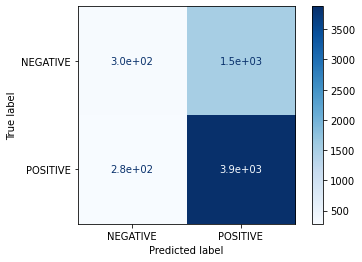

In [17]:
model = LR(solver = 'saga')
model.fit(X_train, y_train)
print('TRAIN')
y_pred = model.predict(X_train)
metrics(y_train,y_pred)
print('TEST')
y_pred = model.predict(X_test)
metrics(y_test,y_pred)
plot_confusion_matrix(model, X_test, y_test,
                      cmap=plt.cm.Blues)

In [18]:
def LR_metrics(X_1, y_1, X_2, y_2):
  model = LR(solver = 'saga',class_weight='balanced')
  model.fit(X_1, y_1)

  print('TRAIN')
  y_pred = model.predict(X_1)
  metrics(y_1,y_pred)

  print('TEST')
  y_pred = model.predict(X_2)
  metrics(y_2,y_pred)
  plot_confusion_matrix(model, X_2, y_2,
                        cmap=plt.cm.Blues)

TRAIN
Error 0.33731517834767355
Precision 0.832374318594791
Recall 0.6522306597057428
F1 0.7313730707823309
TEST
Error 0.3964249916471767
Precision 0.7758567459092313
Recall 0.6040865384615385
F1 0.6792809839167455


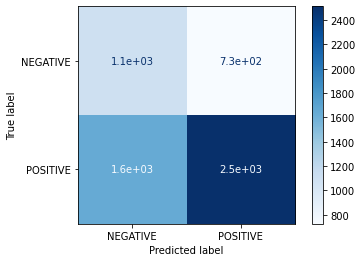

In [19]:
LR_metrics(X_train,y_train,X_test,y_test)

# Feature Selection

In [20]:
def feature_selection_metric(meth):
  selector = meth.fit(X_train, y_train.values.ravel())
  X_1 = selector.transform(X_train)
  X_2 = selector.transform(X_test)
  LR_metrics(X_1, y_train, X_2, y_test)

TRAIN
Error 0.37440481162810124
Precision 0.8081368108699047
Recall 0.6139653535832937
F1 0.697795158789023
TEST
Error 0.39943200801871037
Precision 0.7768388106416275
Recall 0.5966346153846154
F1 0.6749150237933378


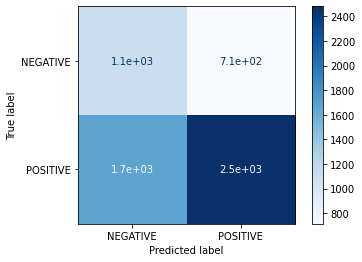

In [21]:
from sklearn.feature_selection import SelectKBest
feature_selection_metric(SelectKBest(k=500))

TRAIN
Error 0.3741959736028736
Precision 0.8082116930762626
Recall 0.6142619838633128
F1 0.6980146290491118
TEST
Error 0.39959906448379556
Precision 0.7767689417658109
Recall 0.5963942307692308
F1 0.6747348381833017


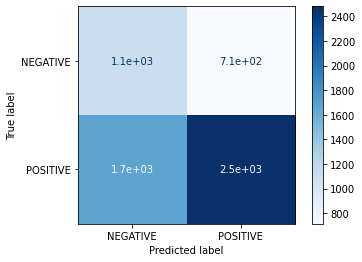

In [22]:
from sklearn.feature_selection import VarianceThreshold
selector = SelectKBest(k=500).fit(X_train, y_train)
feature_selection_metric(selector)

TRAIN
Error 0.3389858825494946
Precision 0.8307599152285801
Recall 0.6511627906976745
F1 0.7300784887588133
TEST
Error 0.39325091881055796
Precision 0.7759779951100244
Recall 0.6103365384615385
F1 0.6832615715823466


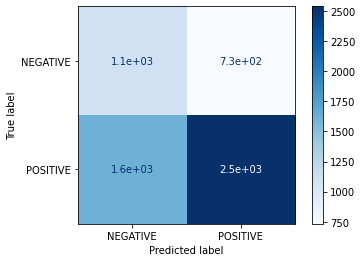

In [23]:
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
selector = SelectFromModel(estimator=LinearSVC()).fit(X_train, y_train)
feature_selection_metric(selector)

TRAIN
Error 0.3424943613733189
Precision 0.8282269073259517
Recall 0.6478998576174656
F1 0.7270487983489782
TEST
Error 0.39542265285666556
Precision 0.7800687285223368
Recall 0.6002403846153846
F1 0.6784404292894987


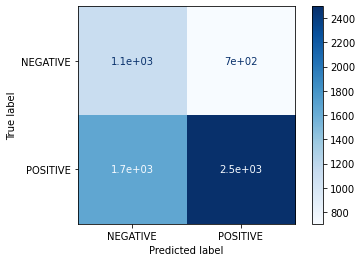

In [24]:
selector = SelectFromModel(estimator=LR()).fit(X_train, y_train)
feature_selection_metric(selector)

TRAIN
Error 0.36433881881212926
Precision 0.8145741471339057
Recall 0.624703369719981
F1 0.7071147970318639
TEST
Error 0.39074507183428
Precision 0.7835565244472127
Recall 0.6048076923076923
F1 0.682675349342016


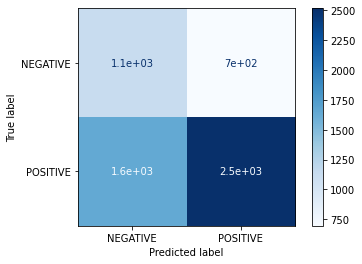

In [25]:
from sklearn.tree import DecisionTreeClassifier
selector = SelectFromModel(estimator=DecisionTreeClassifier()).fit(X_train, y_train)
feature_selection_metric(selector)

# More complex models

TRAIN
Error 0.36091387519839613
Precision 0.8109622227269286
Recall 0.6355007119126721
F1 0.7125893896557459
TEST
Error 0.40227196792515874
Precision 0.7680538555691554
Recall 0.6033653846153846
F1 0.6758212170166935


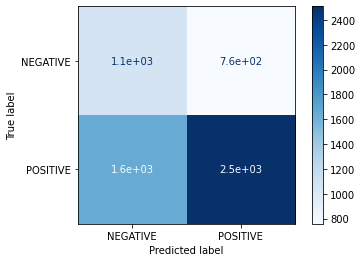

In [31]:
from sklearn.ensemble import AdaBoostClassifier
model = AdaBoostClassifier( DecisionTreeClassifier(max_depth = 1,class_weight='balanced'), n_estimators=100)
model.fit(X_train, y_train)

print('TRAIN')
y_pred = model.predict(X_train)
metrics(y_train,y_pred)
print('TEST')
y_pred = model.predict(X_test)
metrics(y_test,y_pred)

plot_confusion_matrix(model, X_test, y_test,
                      cmap=plt.cm.Blues)

TRAIN
Error 0.0002923732353187214
Precision 0.9998813267667478
Recall 0.999703369719981
F1 0.9997923403245423
TEST
Error 0.3483127297026395
Precision 0.7113465064167855
Recall 0.8394230769230769
F1 0.770095931194178


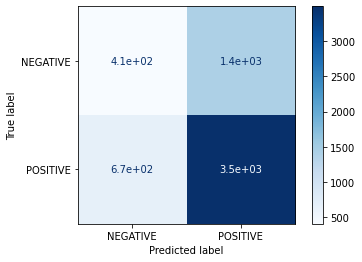

In [26]:
from sklearn.ensemble import AdaBoostClassifier
model = AdaBoostClassifier( DecisionTreeClassifier(class_weight='balanced'), n_estimators=100)
model.fit(X_train, y_train)

print('TRAIN')
y_pred = model.predict(X_train)
metrics(y_train,y_pred)
print('TEST')
y_pred = model.predict(X_test)
metrics(y_test,y_pred)

plot_confusion_matrix(model, X_test, y_test,
                      cmap=plt.cm.Blues)

TRAIN
Error 0.0002923732353187214
Precision 0.9998813267667478
Recall 0.999703369719981
F1 0.9997923403245423
TEST
Error 0.29869695957233544
Precision 0.7035003431708992
Recall 0.9855769230769231
F1 0.8209851822186625


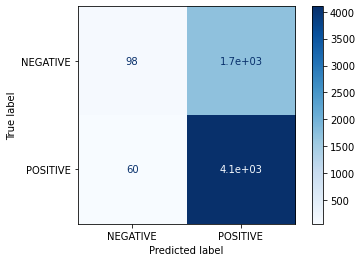

In [27]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100,class_weight='balanced')
model.fit(X_train, y_train)

print('TRAIN')
y_pred = model.predict(X_train)
metrics(y_train,y_pred)
print('TEST')
y_pred = model.predict(X_test)
metrics(y_test,y_pred)

plot_confusion_matrix(model, X_test, y_test,
                      cmap=plt.cm.Blues)

TRAIN
Error 0.0002923732353187214
Precision 0.9998813267667478
Recall 0.999703369719981
F1 0.9997923403245423
TEST
Error 0.39809555629802873
Precision 0.709700259617654
Recall 0.7228365384615385
F1 0.7162081695843754


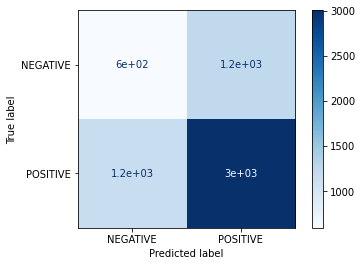

In [28]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(class_weight='balanced')
model.fit(X_train, y_train)

print('TRAIN')
y_pred = model.predict(X_train)
metrics(y_train,y_pred)
print('TEST')
y_pred = model.predict(X_test)
metrics(y_test,y_pred)

plot_confusion_matrix(model, X_test, y_test,
                      cmap=plt.cm.Blues)

TRAIN
Error 0.007685239328376947
Precision 0.9997601918465228
Recall 0.9893213099193165
F1 0.994513358778626
TEST
Error 0.3964249916471767
Precision 0.713807130892558
Recall 0.7170673076923076
F1 0.7154335052164529


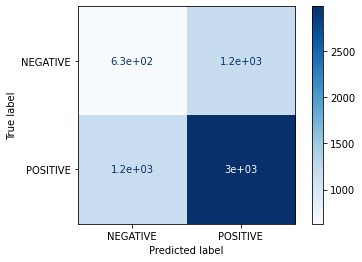

In [29]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(class_weight='balanced',max_depth = 30)
model.fit(X_train, y_train)

print('TRAIN')
y_pred = model.predict(X_train)
metrics(y_train,y_pred)
print('TEST')
y_pred = model.predict(X_test)
metrics(y_test,y_pred)

plot_confusion_matrix(model, X_test, y_test,
                      cmap=plt.cm.Blues)

TRAIN
Error 0.00150363378163898
Precision 0.9985771875741049
Recall 0.9992880873279545
F1 0.9989325109714151
TEST
Error 0.3481456732375543
Precision 0.7323187108325873
Recall 0.7865384615384615
F1 0.7584608252202133


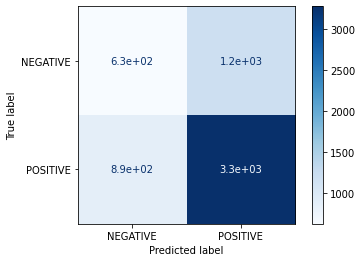

In [30]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scale = scaler.transform(X_train)
X_test_scale = scaler.transform(X_test)

model = MLPClassifier(alpha=1e-5, hidden_layer_sizes=(1000, 500))
model.fit(X_train_scale, y_train)

print('TRAIN')
y_pred = model.predict(X_train_scale)
metrics(y_train,y_pred)
print('TEST')
y_pred = model.predict(X_test_scale)
metrics(y_test,y_pred)

plot_confusion_matrix(model, X_test_scale, y_test,
                      cmap=plt.cm.Blues)